In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
import sklearn
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.io import read_image
import math


In [3]:
train_dir = '../input/petfinder-pawpularity-score/train/'
test_dir = '../input/petfinder-pawpularity-score/test/'

train_csv = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
test_csv = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
submission = pd.read_csv('../input/petfinder-pawpularity-score/sample_submission.csv')

# Path of every image
def create_path(df,root_dir):
    df['Path'] = df['Id'].apply(lambda x: root_dir+x+'.jpg')
    
create_path(train_csv,train_dir)
create_path(test_csv,test_dir)

# Create Label column (used later)
test_csv['Pawpularity'] = 0

In [4]:
train_csv.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000
mean,0.027643,0.772599,0.903955,0.861582,0.009988,0.067797,0.129338,0.049637,0.166263,0.172014,0.061239,0.070420,38.039044
std,0.163957,0.419175,0.294668,0.345356,0.099444,0.251409,0.335591,0.217204,0.372335,0.377411,0.239780,0.255866,20.591990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [5]:
class CustomDataSet(Dataset):
    
    def __init__(self,csv_file,transform=None,augment_transform=None):
        self.csv_file = csv_file
        self.transform = transform
        self.augment_trans = augment_transform
        
        
    def __len__(self):
        return int(self.csv_file.shape[0])
    
    def __getitem__(self,idx):
        img_path = self.csv_file.Path[idx]
        image = read_image(img_path)
        label = self.csv_file.Pawpularity[idx]
        image = image.type(torch.FloatTensor)
        
        if self.transform:
            image = self.transform(image)
        if self.augment_trans:
            image = self.augment_transform(image)
           
        image = torch.mul(image, (1/255))
        return image,label

In [6]:
from torch.utils.data.sampler import SubsetRandomSampler
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
                                normalize,
                                transforms.Resize(255),
                                transforms.CenterCrop(224)])
train_dataset = CustomDataSet(train_csv,transform) 
test_data = CustomDataSet(test_csv,transform)


#test_data = CustomDataSet(test_csv,transform)



len_train = len(train_dataset)


split = int(np.floor(0.85 * len_train))
list_indices = [x for x in range(len_train)]
np.random.seed(42)
np.random.shuffle(list_indices)
train_indices , val_indices = list_indices[split:], list_indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_split = 0.7 * len(train_dataset)
val_split = len(train_dataset) - train_split
#train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_split,val_split])

train_dataloader = DataLoader(train_dataset, batch_size=64, 
                                           sampler=valid_sampler)
validation_dataloader = DataLoader(train_dataset, batch_size=64,
                                                sampler=train_sampler)


#train_dataloader = {x:DataLoader(train_data[x],batch_size=64,shuffle=True) for x in ['train','val']}
test_dataloader = DataLoader(test_data,batch_size=64,shuffle=True)

#train_size  = {x: len(train_data[x]) for x in ['train', 'val']}
#train_size['val']
print(len(test_dataloader.dataset))

8


In [7]:
len(validation_dataloader)

24

<AxesSubplot:>

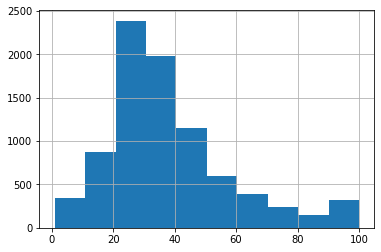

In [8]:
train_csv.Pawpularity[val_indices].hist()

<AxesSubplot:>

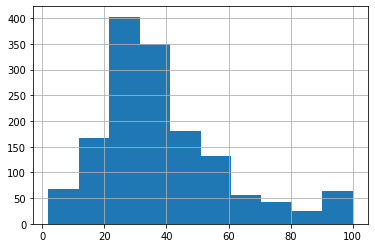

In [9]:
train_csv.Pawpularity[train_indices].hist()

In [10]:
# img1 = plt.imread(train_csv.Path[64])
# img1=img1.reshape(img1.shape[1],img1.shape[2],3)
# print(img1.shape)
# plt.axis('off')
# plt.imshow(img1)
# plt.show()

tensor(4.4563)
Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])
150528


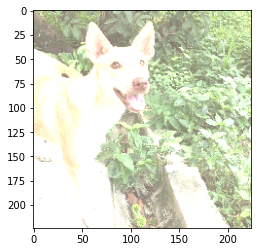

Label: 7


In [11]:
train_image, train_labels = next(iter(train_dataloader))
test_image, test_labels = next(iter(test_dataloader))

print(train_image[62].max())

print(f"Feature batch shape: {train_image.size()}")
print(f"Labels batch shape: {train_labels.size()}")
#img = np.transpose(img,(1,0,2))
#img = train_image[62].reshape(224,224,3).squeeze()
inp = train_image[62]
inp = inp.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)
print(inp.size)
label = train_labels[0]
plt.imshow(inp)
plt.show()
print(f"Label: {label}")

In [12]:
valid_image,valid_label = next(iter(validation_dataloader))
print(valid_image[62].max())

tensor(4.4187)


In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
import time
import copy

cuda:0


In [14]:
def train_model2(model,criterion,optimizer,num_epochs=15,split=0.9):
    min_val_loss = np.Inf
    best_model_wts = copy.deepcopy(model.state_dict())
    since = time.time()
    for epoch in range(num_epochs):
        valid_loss=0.0
        train_loss = 0.0
        model.train()
        
        
        for iter1,(inputs,labels) in enumerate(train_dataloader):
            
            inputs = inputs.to(device)
            inputs = inputs.type(torch.float)
            labels = labels.to(device).view(labels.shape[0],1)
            labels = labels.type(torch.float)
            
            optimizer.zero_grad()
            out = model(inputs)
            #out=torch.maximum(out,torch.tensor(100,device=device))
            #out = torch.mul(out,100)
            loss = criterion(out,labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            
            print(
                f'Epoch: {epoch}\t{100 * (iter1 + 1) / len(train_dataloader):.2f}'+'%',
                end='\r')
            
        
        else:
            print()
            with torch.no_grad():
                model.eval()
                
            
            for iter2,(inputs,labels) in enumerate(validation_dataloader):
                
                inputs = inputs.to(device)
                inputs = inputs.type(torch.float)
                labels = labels.to(device).view(labels.shape[0],1)
                labels = labels.type(torch.float)
                
                output1 = model(inputs)
                #output1=torch.maximum(output1,torch.tensor(100,device=device))
                #output1 = torch.mul(output1,100).to(device)
                loss = criterion(output1,labels)
                valid_loss += loss.item() * inputs.size(0)
                print(
                f'Epoch: {epoch}\t{100 * (iter2 + 1) / len(validation_dataloader):.2f}'+' %',
                end='\r')
        len_train1 = int(np.floor(0.85 * len_train))
        len_val1 = len_train - len_train1
        train_loss = train_loss / len_train1
        valid_loss = valid_loss / len_val1
        
        print(f'\nEpoch: {epoch} \tTraining Loss: {math.sqrt(train_loss):.4f} \tValidation Loss: {math.sqrt(valid_loss):.4f}')
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        
        if valid_loss < min_val_loss:
            min_val_loss = valid_loss
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
        print('Best val Loss: {:4f}'.format(math.sqrt(min_val_loss)))    
            
    model.load_state_dict(best_model_wts)
    return model

In [15]:
def mul_100(x):
    
    res2 = torch.mul((x),100)
    return res2


In [16]:
# model_ft1 = torchvision.models.densenet201(pretrained=True)
# # print(model_ft1)

# for params in model_ft1.parameters():
#     params.requires_grad = False
    
# # #num_filters = model_ft1.fc.in_features

# # model_ft1 = model_ft1.to(device)

In [17]:
#torch.save(model_ft1,'./DenseNet201.pth')

In [18]:
# model_ft1

In [19]:
# model_sub3 = nn.Sequential(model_ft1,
#                           nn.Flatten(),
#                            nn.Linear(1000,1)
                           
#                            ).to(device)

In [20]:
# model_sub3


In [21]:
#model_f = nn.Sequential(model_ft,nn.Sigmoid())

In [22]:
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.002)
#criterion = nn.MSELoss()


#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

In [23]:
len(train_dataloader.dataset)

9912

In [24]:
%%time
#model = train_model2(model_ft, criterion, optimizer_ft,num_epochs=3)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [25]:
#torch.cuda.empty_cache()

In [26]:
#torch.save(model_sub1,'./Lin_DenseNet201.pth')

In [27]:
model_sub3 = torch.load('../input/densenet201/Lin_DenseNet201(1).pth',map_location=torch.device(device)).cuda()

In [28]:
model_sub = nn.Sequential(model_sub3,nn.Linear(1000,1),nn.ReLU())
model_sub = model_sub.to(device)

In [29]:
%%time

optimizer_sub = optim.SGD(model_sub.parameters(), lr=0.001)
criterion_sub = nn.MSELoss()


model_sub1 = train_model2(model_sub,criterion_sub, optimizer_sub,num_epochs=43)

Epoch: 0	100.00%
Epoch: 0	100.00 %
Epoch: 0 	Training Loss: 20.7960 	Validation Loss: 19.7861
Training complete in 6m 17s
Best val Loss: 19.786065
Epoch: 1	100.00%
Epoch: 1	100.00 %
Epoch: 1 	Training Loss: 19.4370 	Validation Loss: 19.9299
Training complete in 11m 45s
Best val Loss: 19.786065
Epoch: 2	100.00%
Epoch: 2	100.00 %
Epoch: 2 	Training Loss: 19.2954 	Validation Loss: 19.4320
Training complete in 17m 11s
Best val Loss: 19.431973
Epoch: 3	100.00%
Epoch: 3	100.00 %
Epoch: 3 	Training Loss: 19.1082 	Validation Loss: 20.0599
Training complete in 22m 38s
Best val Loss: 19.431973
Epoch: 4	100.00%
Epoch: 4	100.00 %
Epoch: 4 	Training Loss: 19.1709 	Validation Loss: 19.4521
Training complete in 28m 7s
Best val Loss: 19.431973
Epoch: 5	100.00%
Epoch: 5	100.00 %
Epoch: 5 	Training Loss: 18.9975 	Validation Loss: 19.2056
Training complete in 33m 36s
Best val Loss: 19.205629
Epoch: 6	100.00%
Epoch: 6	100.00 %
Epoch: 6 	Training Loss: 18.9152 	Validation Loss: 19.7204
Training complete in

In [30]:
torch.save(model_sub1,'./DenseNet201_lin_trained.pth')

In [31]:
#outputs = model_sub1(validation_dataloader)

In [32]:
# %%time
# for iter2,(inputs,labels) in enumerate(validation_dataloader):
                
#                 inputs = inputs.to(device)
#                 inputs = inputs.type(torch.float)
#                 labels = labels.to(device).view(labels.shape[0],1)
#                 labels = labels.type(torch.float)
                
#                 output2 = model_sub1(inputs)
                
                
                
# for i in range(len(output2)):
    
#     print(output2[i],i)
        
        
        
        
        


In [33]:
# train_csv['Model_output'] = 0
# #train_csv['Model_output'][train_indices] = output2
# loss=0.0
# loss_item=0.0
# op=0
# for i in train_indices:
#     loss_item=np.sqrt(np.square(train_csv['Pawpularity'])-np.square(train_csv['Model_output']))
#     if (loss_item==0):
#         op+=1
#     loss += loss_item
    
# loss/= (len(validation_dataloader)*64)
# print(loss)
# print(op)

In [34]:
# with torch.no_grad:
model_sub1.eval()
out_test = torch.tensor([0.00])

for iter2,(inputs,labels) in enumerate(test_dataloader):
    
    model_sub1.eval()
    with torch.no_grad():
        inputs = inputs.to(device)
        inputs = inputs.type(torch.float)
        labels = labels.type(torch.float)
        labels = labels.to(device).view(labels.shape[0],1)


        output1 = model_sub1(inputs).cpu()
        output1 = torch.flatten(output1)
        out_test = torch.cat((out_test,output1))
        out_test = torch.flatten(out_test)
        type(output1)

                    
        
                
                    
    
   
                #output1 = torch.mul(output1,100).to(device)
                #loss = criterion(output1,labels)
                #valid_loss += loss.item() * inputs.size(0)
#                 print(
#                 f'Epoch: {epoch}\t{100 * (iter2 + 1) / len(validation_dataloader):.2f}'+' %',
#                 end='\r')

    
print(out_test.shape)

torch.Size([9])


In [35]:
out_test = out_test[1:]
print(out_test.shape)

torch.Size([8])


In [36]:
out_test = out_test.numpy().squeeze()

In [37]:
# y_pred_df = pd.DataFrame(np.stack(out_test.cpu().detach().numpy(), axis=0))
# y_pred_df["mean"] = y_pred_df.mean(axis=1)

In [38]:
for i in out_test:
    print(i)

40.470333
42.28342
40.627052
40.026005
40.915253
37.410343
41.94598
42.78678


In [39]:


# y_pred_df.to_csv("y_pred.csv", index=False)



In [40]:


submission["Pawpularity"] = out_test
submission.to_csv("submission.csv", index=False)
submission



,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,40.470333
1,43a2262d7738e3d420d453815151079e,42.283421
2,4e429cead1848a298432a0acad014c9d,40.627052
3,80bc3ccafcc51b66303c2c263aa38486,40.026005
4,8f49844c382931444e68dffbe20228f4,40.915253
5,b03f7041962238a7c9d6537e22f9b017,37.410343
6,c978013571258ed6d4637f6e8cc9d6a3,41.945980
7,e0de453c1bffc20c22b072b34b54e50f,42.786781


In [41]:
out_test[0]

40.470333

In [42]:
valid_label[0]

tensor(23)

In [43]:
# for i in range(0,len(out_test)):
#     submission.Pawpularity[i] = out_test[i]
#     print(output1[i])
#     print(i)
    
    


# #print(model_sub1)

In [44]:
# for i in range(8):
#     print(submission.Pawpularity[i])

In [45]:

# submission.to_csv("submission.csv", index = False)
# print("Submission Success")